In this project, we try to build a model that can predict whether a certain passenger would have survived the titanic crash. This is famous data science competition on Kaggle! We do some data analysis to find important variables, some data processing and feature engineering to get our data ready for the model, create (and tune) the model using hyperparameter tuning, and finally validate our model using performance metrics. 

In [60]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [63]:
# split into training and testing data
X = pd.read_csv("train.csv")
X_copy = X.copy()
y = X["Survived"]
X.drop(["Survived"], axis = 1, inplace = True)

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size = 0.2, random_state = 1)
full_data = [train_X, val_X]


In [18]:
X.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [48]:
# Cabin has too many null values, so we can drop it
# Passenger Id and Ticket are pretty unique for each individual and are used merely for identification, not helping us in our model
for dataset in full_data:
    dataset.drop(["PassengerId", "Ticket", "Cabin"], axis = 1, inplace= True)

train_X.head()

/Users/devpatel917/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
301,3,"McCoy, Mr. Bernard",male,NaN,2,0,23.2500,Q
309,1,"Francatelli, Miss. Laura Mabel",female,30.0,0,0,56.9292,C
516,2,"Lemore, Mrs. (Amelia Milley)",female,34.0,0,0,10.5000,S
120,2,"Hickman, Mr. Stanley George",male,21.0,2,0,73.5000,S
570,2,"Harris, Mr. George",male,62.0,0,0,10.5000,S


In [ ]:
# filling null values 
for dataset in full_data:
    col_means = dataset.mean()
    dataset.fillna(col_means)

    dataset["Embarked"] = dataset["Embarked"].fillna("S")



    

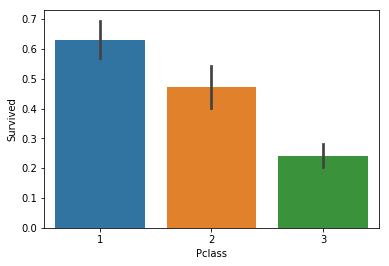

In [49]:
sns.barplot('Pclass','Survived', data=X_copy)
plt.show()

We can see that Pclass can tell us the likelihood of survival pretty well, so we want to use Pclass in our model. Passengers from Pclass 1 had the highest survival rate, which makes sense as wealthier people had better chances of survival

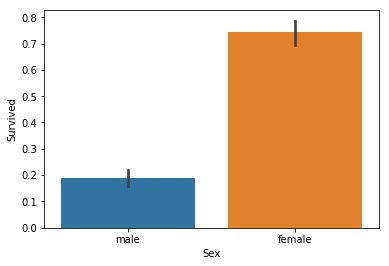

In [50]:
sns.barplot(x='Sex', y='Survived', data=X_copy)
plt.show()

Sex is also an important feature in relationship to survival. As expected, females had a much higher survival rate, probably because women were first prioritized to get in life boats. 

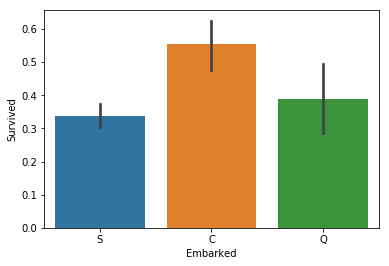

In [51]:
sns.barplot(x='Embarked', y='Survived', data=X_copy)
plt.show()

C has the greatest survival rate. However, we do not see such stark differences in survival rates acorss the different locations. 

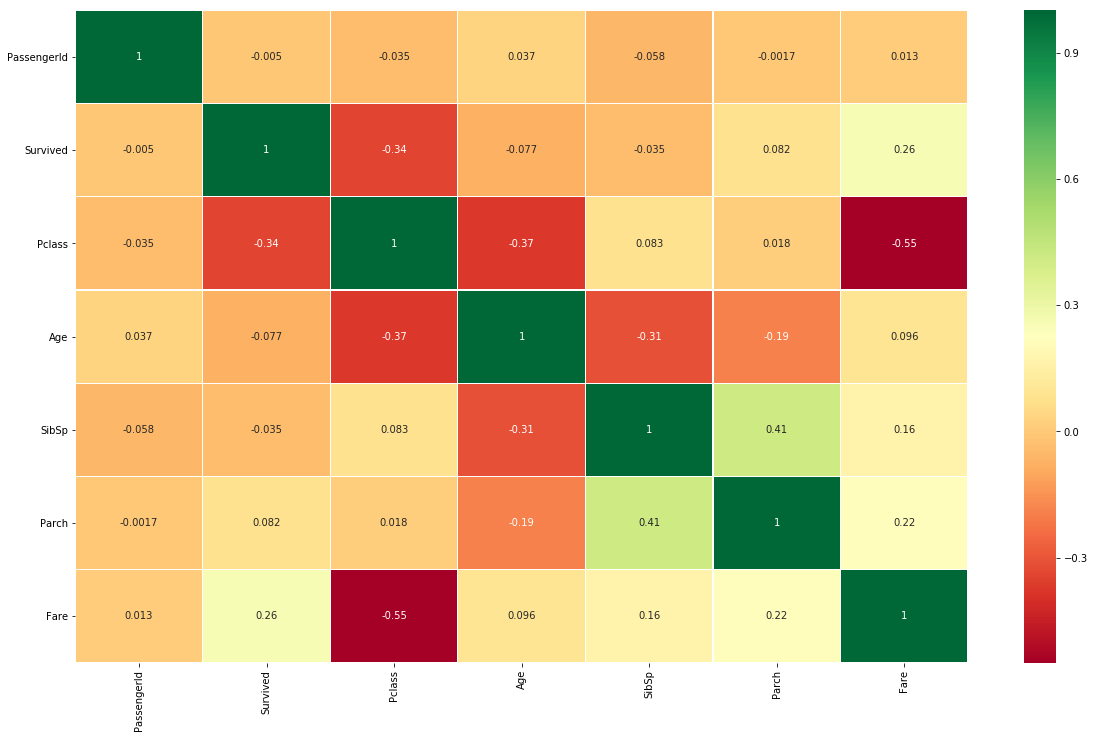

In [52]:
sns.heatmap(X_copy.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

If there is a high correlation, then both features are containing similar information and there is little to no variance in information (multicolinearity). When training the model, it's important to eliminate redundant features. In this case, most of the features are not highly correlated with one another. 

The highest correlation is between Parch and SibSp. We would combine those two to engineer another feature called family size

In [56]:
# feature engineering family size (1 is added to account for the passenger) 
for dataset in full_data:
    dataset["Family_Size"] = dataset["Parch"] + dataset["SibSp"] + 1

    dataset.drop(["Parch", "SibSp"], axis = 1, inplace = True)

/Users/devpatel917/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Additionally, the names do not provide much value. However, the title of these names do. 

In [64]:
# making new feature - title from Name
for dataset in full_data:
    dataset["Name"] = dataset.apply(lambda x: x["Name"][x["Name"].index(",") + 1:x["Name"].index(".")].strip(), axis = 1)
    dataset["Name"] = dataset.apply(lambda x: "Miss" if (x["Name"] == "Mlle") else x["Name"], axis = 1)
    dataset["Name"] = dataset.apply(lambda x: "Miss" if (x["Name"] == "Ms") else x["Name"], axis = 1)
    dataset["Name"] = dataset.apply(lambda x: "Mrs" if (x["Name"] == "Mme") else x["Name"], axis = 1)   

    rare_class = ["Dr", "Rev", "Major", "Col", "Sir", "Lady", "Jonkheer", "the Countess", "Don", "Capt", "Dona"]
    dataset["Name"] = dataset.apply(lambda x: "Rare" if (x["Name"] in rare_class) else x["Name"], axis = 1)

   


/Users/devpatel917/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/devpatel917/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/devpatel917/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [65]:
for dataset in full_data:
    dataset["Title"] = dataset["Name"]
    dataset.drop(["Name"], axis = 1, inplace = True)

/Users/devpatel917/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/devpatel917/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [70]:
sns.barplot(x='Title', y='Survived', data=train_X)

ValueError: Could not interpret input 'Survived'